# Importing Module and define directories

In [6]:
project_dir = '../../'
data_dir = project_dir + 'data/'

import sys
sys.path.append(project_dir + 'NN/')

import numpy as np
import seaborn as sns
import pandas as pd
import importlib
import time
import matplotlib.pyplot as plt
import MLP
import layer
importlib.reload(MLP)
importlib.reload(layer)
from MLP import MLP
from utils.preprocessing import split,Normalize

In [2]:
def plot_results(network):
    train_pred = network.predict(input_data)
    val_pred = network.predict(val_data)
    x = np.arange(len(network.train_MEE))

    fig = plt.figure(figsize=(13,4))

    fig.add_subplot(131)
    plt.plot(x,network.train_MEE)
    plt.plot(x,network.val_MEE,label="test")
    plt.title("Learning curve")
    plt.xlabel("Epochs")
    plt.ylabel("Squared error")
    plt.yscale("log")
    plt.legend()

    fig.add_subplot(132)
    plt.title('Residual for training data')
    plt.plot(np.arange(len(labels)),labels[:,0]-train_pred[:,0],".",label="residual0")
    plt.plot(np.arange(len(labels)),labels[:,1]-train_pred[:,1],".",label="residual1")
    plt.legend()

    fig.add_subplot(133)
    plt.title('Residual for validation data')
    plt.plot(np.arange(len(val_labels)),val_labels[:,0]-val_pred[:,0],".",label="residual0")
    plt.plot(np.arange(len(val_labels)),val_labels[:,1]-val_pred[:,1],".",label="residual1")
    plt.legend()
    plt.tight_layout()
    plt.show()
    netw.predict(input_data)


# Train - Validation Split

In [3]:
raw_data=np.loadtxt("../../data/TR.csv",delimiter=",")[:,1:]
data = raw_data[:,:10] ; labels = raw_data[:,-2:]

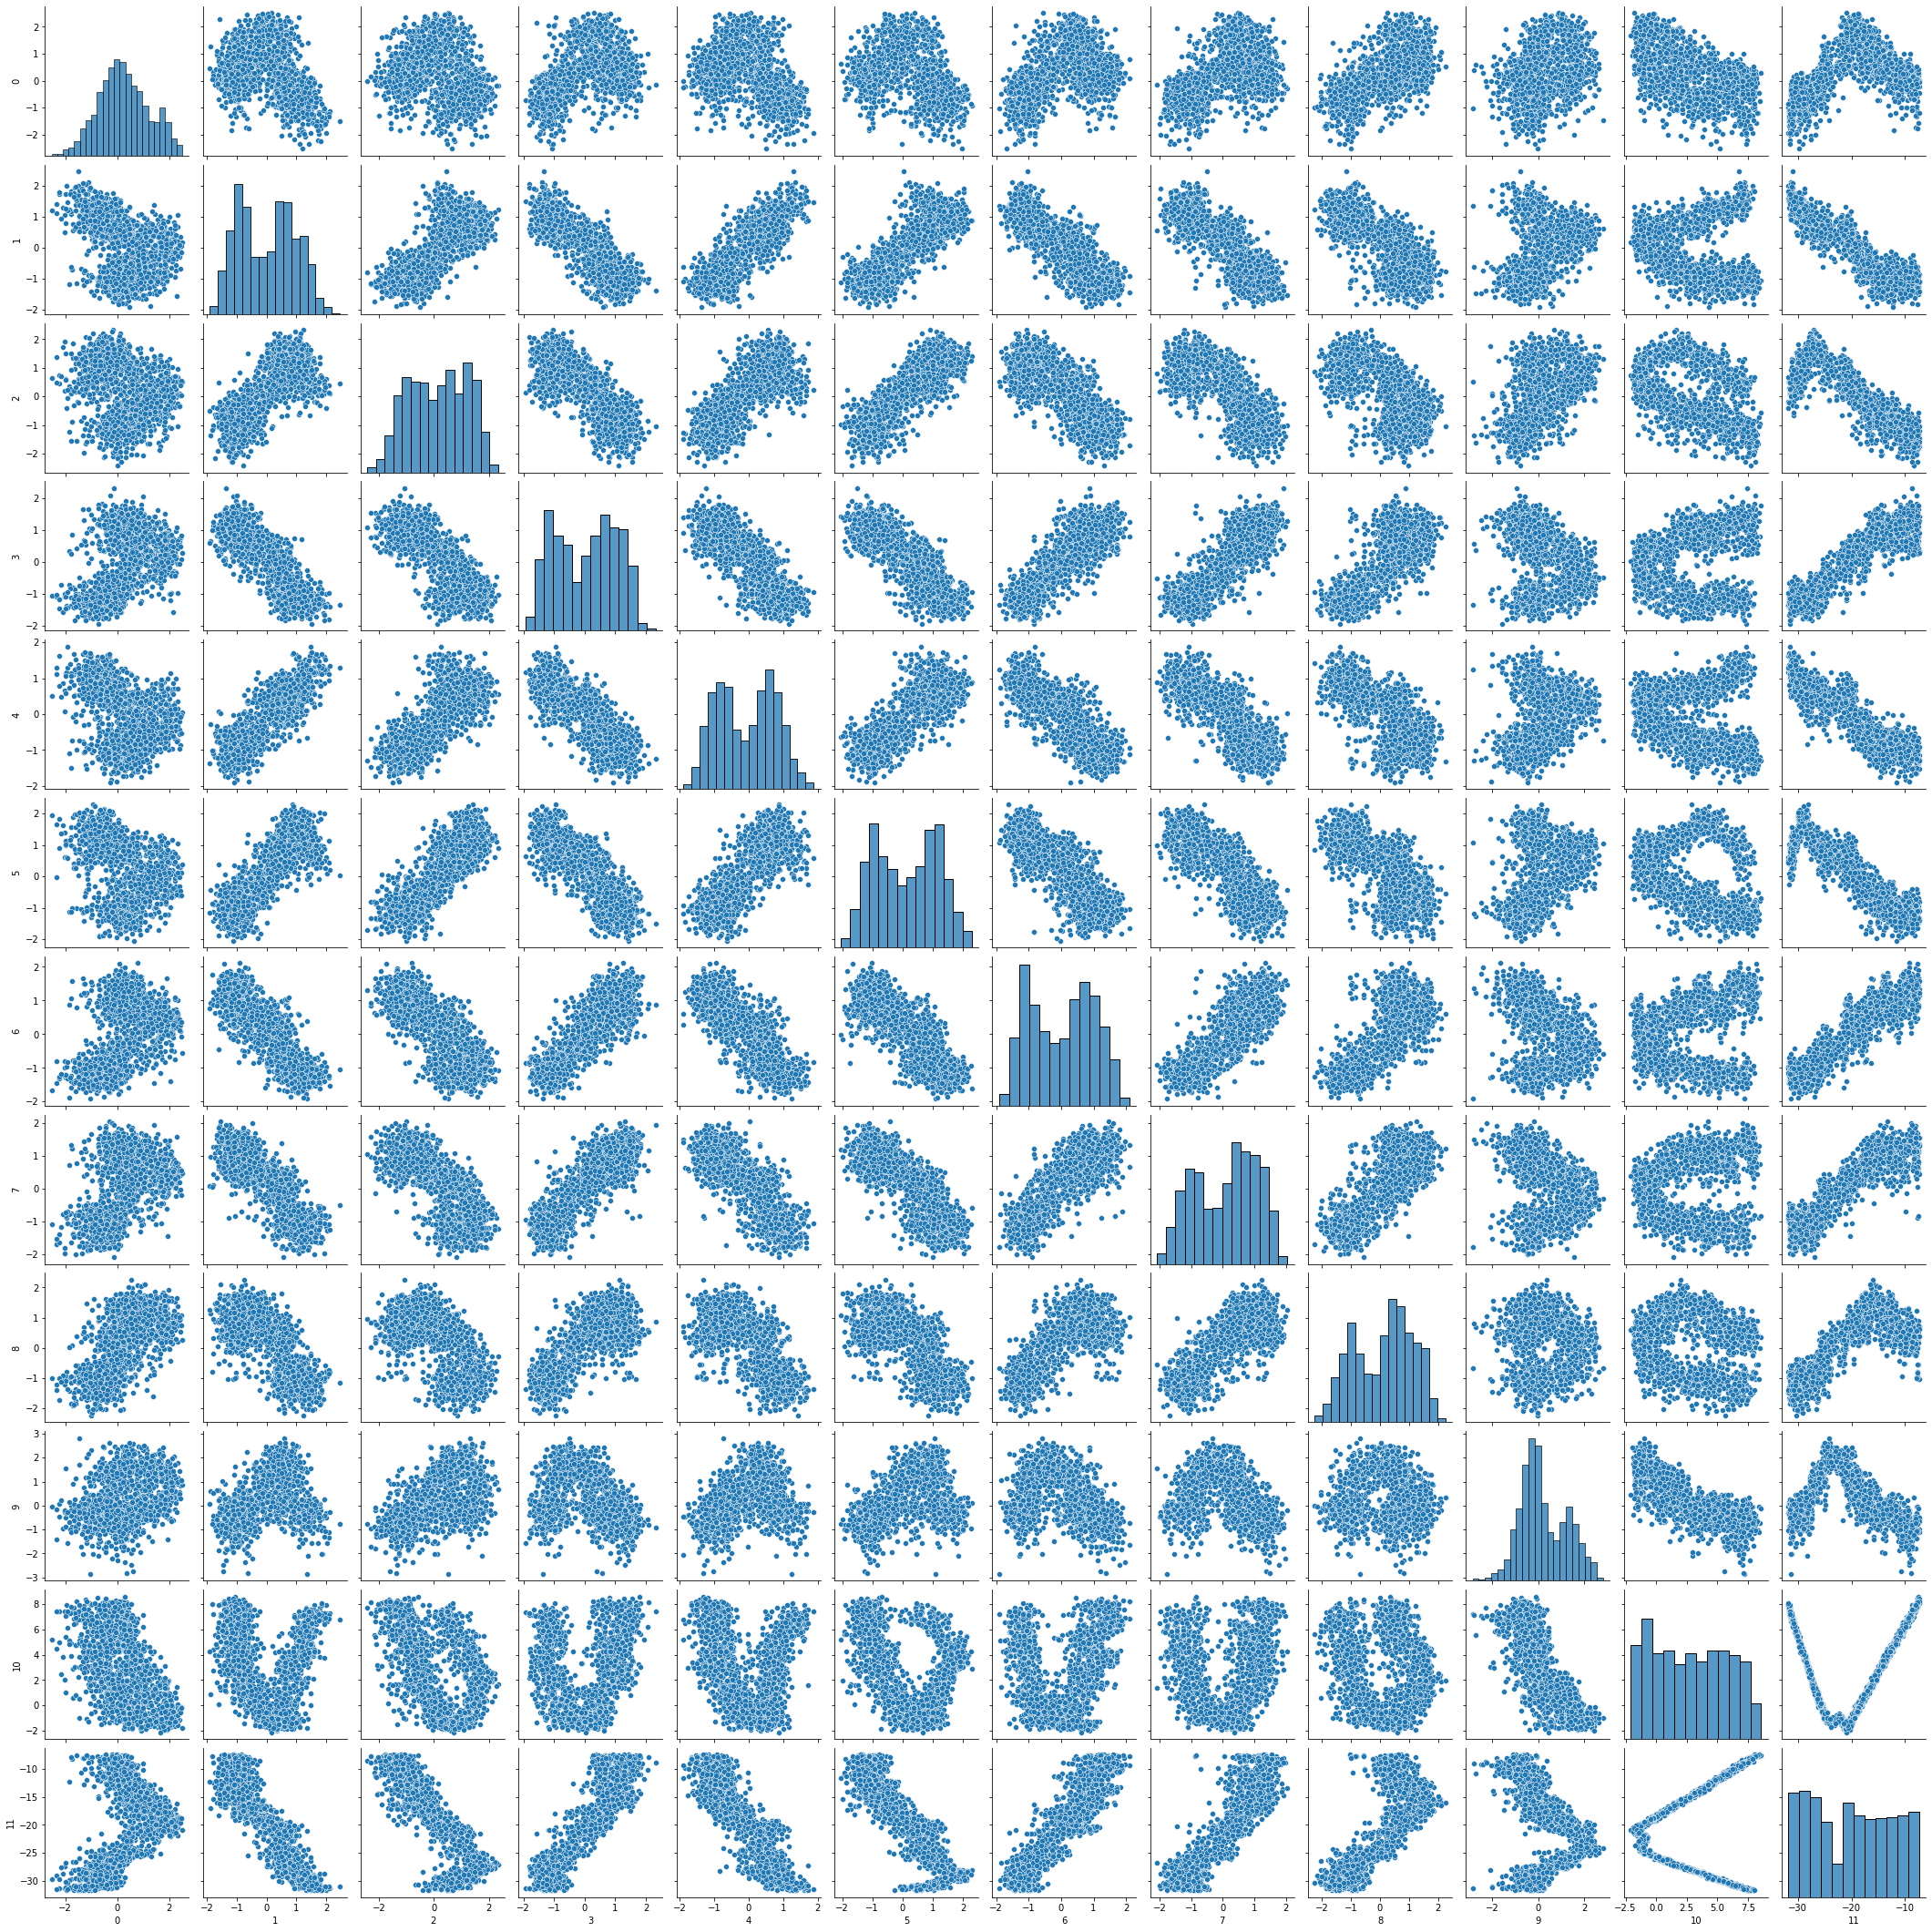

In [9]:
sns.pairplot(pd.DataFrame(raw_data))

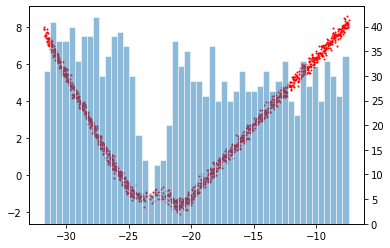

In [28]:
hard_out = raw_data[:, 11]
easy_out = raw_data[:, 10]

fig, ax_left = plt.subplots()
ax_right = ax_left.twinx()

ax_left.scatter(hard_out, easy_out, s = 1, c='red')
ax_right.hist(hard_out, bins = 50, alpha = 0.5, ec="white")
plt.show()

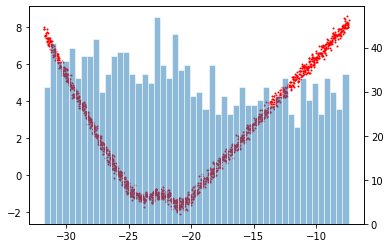

In [88]:
def generate_in_middle(dataset, d1, d2):
    mid = (dataset[d1, :] + dataset[d2, :])/2
    return np.row_stack((dataset, mid))

def expand_in_middle(n_new_data, dataset, lim_inf, lim_sup, unbal_feature):
    data_copy = np.copy(dataset)
    mask_inf = data_copy[:, unbal_feature] > lim_inf
    mask_sup = data_copy[:, unbal_feature] < lim_sup
    mid_data = data_copy[np.logical_and(mask_inf, mask_sup)]
    rng = np.random.default_rng()
    for i in range(n_new_data):
        val = rng.normal(loc = (lim_inf + lim_sup)/2, 
                         scale = np.abs((lim_inf - lim_sup)/2))
        sort_for_val = np.argsort(np.abs(data_copy[:,unbal_feature]-val))
        d1 = sort_for_val[0]
        d2 = sort_for_val[1]
        data_copy = generate_in_middle(data_copy, d1, d2)
    return data_copy

new_dataset = expand_in_middle(150, raw_data, -24, -22, 11)

hard_out = new_dataset[:, 11]
easy_out = new_dataset[:, 10]

fig, ax_left = plt.subplots()
ax_right = ax_left.twinx()

ax_left.scatter(hard_out, easy_out, s = 1, c='red')
ax_right.hist(hard_out, bins = 50, alpha = 0.5, ec="white")
plt.show()

In [89]:
sns.pairplot(pd.DataFrame(new_dataset))

In [133]:
input_data=raw_data[:,:-2]
input_labels=raw_data[:,-2:]

frac_test=0.15
data, test_set, labels, test_labels = split(input_data, input_labels, 
                                            kind="hold_out",frac_training=1-frac_test)

data = np.column_stack((data, labels))
new_dataset = expand_in_middle(30, data, -24, -22, 11)
data, labels = data[:,:-2], data[:, -2:]

frac_training=0.8
input_data, val_data, train_labels, val_labels=split(data, labels,kind="hold_out",
                                               frac_training=frac_training)

In [134]:
#xavier weight inizialization
def xavier(structure):
    start=np.zeros(len(structure))
    for idx,num in enumerate(structure):
        if idx==0:
            start[idx]=np.sqrt(6)/np.sqrt(structure[idx])
        else:
            start[idx]=np.sqrt(6)/np.sqrt(structure[idx-1]+structure[idx])
    return list(start)


# Define the MLP

In [153]:
structure=[20,5,3,2]
print(structure)
act_func=[("sigmoid",1),("sigmoid",1), ("sigmoid",1),("linear",1)]
start=xavier(structure)

netw = MLP(structure, func=act_func,
           starting_points=start)

[20, 5, 3, 2]


In [154]:
start

[0.5477225575051661,
 0.4898979485566356,
 0.8660254037844385,
 1.0954451150103321]

## Train the model

In [155]:
rho = 0.01
eta_0 = 6e-5
eta_stop = 0.0001
delta=1e-7
kind="eta_decay"
def eta_function(eta_start, eta_decay, # Mandatory parameters
                 train_MEE=None, val_MEE=None, epoch=None): # Parameters of the training (and of the MLP)
    return eta_start * np.exp(-eta_decay * epoch)
eta_params = [eta_0, rho, 'train_MEE', 'val_MEE', 'epoch'] # Pass in list like that:
# First the mandatory parameters and then the attribute of the class to extract
eta_function=1e-2

In [ ]:
N_epoch = 500 ; k = 6 ; min_index = 0 ; list_cand = [] 
lamb=0
batch_size = 30 #-1 for batch gradient descent
alpha=0.2
nesterov=True
eta_function=1e-3
beta=0.2
tr_kfold = np.array([])
val_kfold = np.array([])
for i in range (0,k):
    netw = MLP(structure, func=act_func,starting_points=start)
    TR_set, VL_set, TR_lab, VL_lab = split(data,labels,kind="hold_out")
    netw.train(TR_set,TR_lab , VL_set, VL_lab,
            epoch = N_epoch,
            batch_size=batch_size,
            eta = eta_function, eta_params = eta_params, lamb = lamb,alpha=alpha,
            nesterov=nesterov,RMSProp=True,beta=beta)
    tr_kfold = np.append(tr_kfold,netw.train_MEE[N_epoch-1])
    val_kfold = np.append(val_kfold,netw.val_MEE[N_epoch-1])
    list_cand.append(netw)
min_index = np.argmin(val_kfold)
#print(tr_kfold, val_kfold) 
#calculate the mean on the k-fold
print('val error : ',np.mean(val_kfold) ,'+/-' ,np.std(val_kfold))
print('training error :',np.mean(tr_kfold),'+/-',np.std(tr_kfold))
print('the best result is :' ,val_kfold[min_index])

# Plot results

In [151]:
pred=list_cand[min_index].predict(data)
plt.plot(labels[:,1],labels[:,0],".")
plt.plot(pred[:,1],pred[:,0],".")

In [ ]:
#numpy correlation matrix for input_data features
corr_matrix=np.corrcoef(raw_data,rowvar=False)

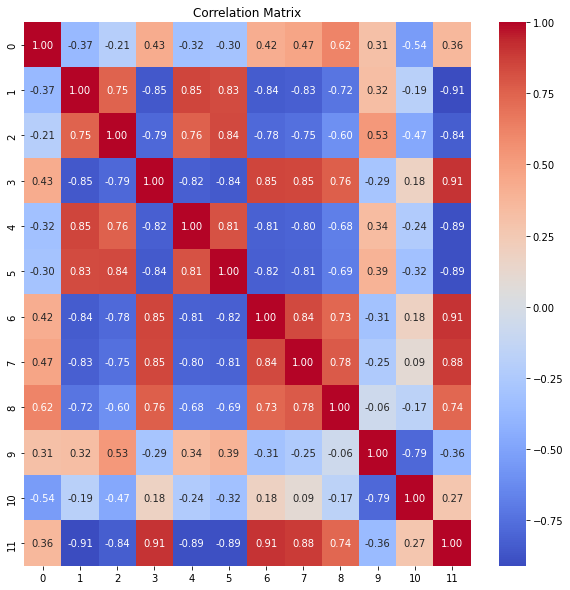

In [ ]:
import seaborn as sns
#matplotlib heat map matrix for input_data features
plt.figure(figsize=(10,10))
plt.title("Correlation Matrix")
sns.heatmap(corr_matrix,annot=True,fmt=".2f",cmap="coolwarm")
plt.show()


In [ ]:
from keras.layers import Input, Dense
from keras.models import Model
inp=Input(shape=(9,))
hidden=Dense(40,activation='sigmoid')(inp)
output=Dense(2,activation='linear')(hidden)

model=Model(inputs=inp,outputs=output)
model.compile(optimizer='adam',loss='mse')
model.fit(input_data,labels,epochs=1000,verbose=1)

ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
model.fit(input_data,labels,epochs=1000,verbose=1)

In [ ]:
pred=model.predict(val_data)
tr=model.predict(input_data)
#plt.plot(labels[:,1],labels[:,0],".")
plt.plot(tr[:,1],tr[:,0],".")
#plt.plot(pred[:,1],pred[:,0],".")